Class trader

Def analyze(lookback)
    Get data and coint pair
    Get optimal rolling window and entry exit

Def trade(period)
     Normal trades with position pnl etc

Def run(date range)
   Counter = 1
   For date in date
         trade
         Counter +=1
        If counter > n:
            Analyze, counter =0

In [59]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [30]:
pair_1_tickers = ["MU","NVDA"]

start = dt.datetime(2024,6,1)
end = dt.datetime(2024,12,1)

pair_1_data = yf.download(pair_1_tickers, start, end)['Close']

[*********************100%***********************]  2 of 2 completed


In [31]:
pair_1_data

Ticker,MU,NVDA
Date,,
2024-06-03,127.581894,114.962219
2024-06-04,126.058907,116.398750
2024-06-05,133.096451,122.399780
2024-06-06,129.473175,120.958252
2024-06-07,130.339157,120.848289
...,...,...
2024-11-22,102.373528,141.927155
2024-11-25,104.208755,135.998123
2024-11-26,101.535706,136.897980


In [32]:
class trader:
    def __init__(self,x_data,y_data,lookback):
        self.x_data = x_data
        self.y_data = y_data
        self.lookback = lookback

In [33]:
x_data.shape
y_data.shape

(126,)

In [79]:
y_data = pair_1_data["MU"]
x_data = pair_1_data["NVDA"]

In [94]:
x_data.iloc[:] 

Date
2024-06-03    114.962219
2024-06-04    116.398750
2024-06-05    122.399780
2024-06-06    120.958252
2024-06-07    120.848289
                 ...    
2024-11-22    141.927155
2024-11-25    135.998123
2024-11-26    136.897980
2024-11-27    135.318222
2024-11-29    138.227768
Name: NVDA, Length: 126, dtype: float64

In [111]:
def compute_spread(lookback=None):
    x = x_data.iloc[:lookback] 
    y = y_data.iloc[:lookback]
    
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    intercept = model.params[0]
    beta = model.params[1]
    spread = y - (intercept + beta*x)
    return spread

In [112]:
compute_spread(90)

C:\Users\lOvIn\AppData\Local\Temp\ipykernel_4268\843259403.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]
C:\Users\lOvIn\AppData\Local\Temp\ipykernel_4268\843259403.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


Date
2024-06-03    23.836294
2024-06-04    20.280065
2024-06-05    18.823855
2024-06-06    17.240894
2024-06-07    18.262515
                ...    
2024-10-03   -13.440422
2024-10-04   -15.941383
2024-10-07   -19.130834
2024-10-08   -26.816225
2024-10-09   -27.314412
Length: 90, dtype: float64

In [160]:
def compute_z_score(lookback=None, rolling_window=None):
    spread = compute_spread(lookback)
    rolling_mean = spread.rolling(window=rolling_window).mean()
    rolling_std = spread.rolling(window=rolling_window).std()
    z_scores = (spread - rolling_mean) / rolling_std
    return z_scores

# + zscore price over mean
# - zscore price below mean

C:\Users\lOvIn\AppData\Local\Temp\ipykernel_4268\843259403.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]
C:\Users\lOvIn\AppData\Local\Temp\ipykernel_4268\843259403.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


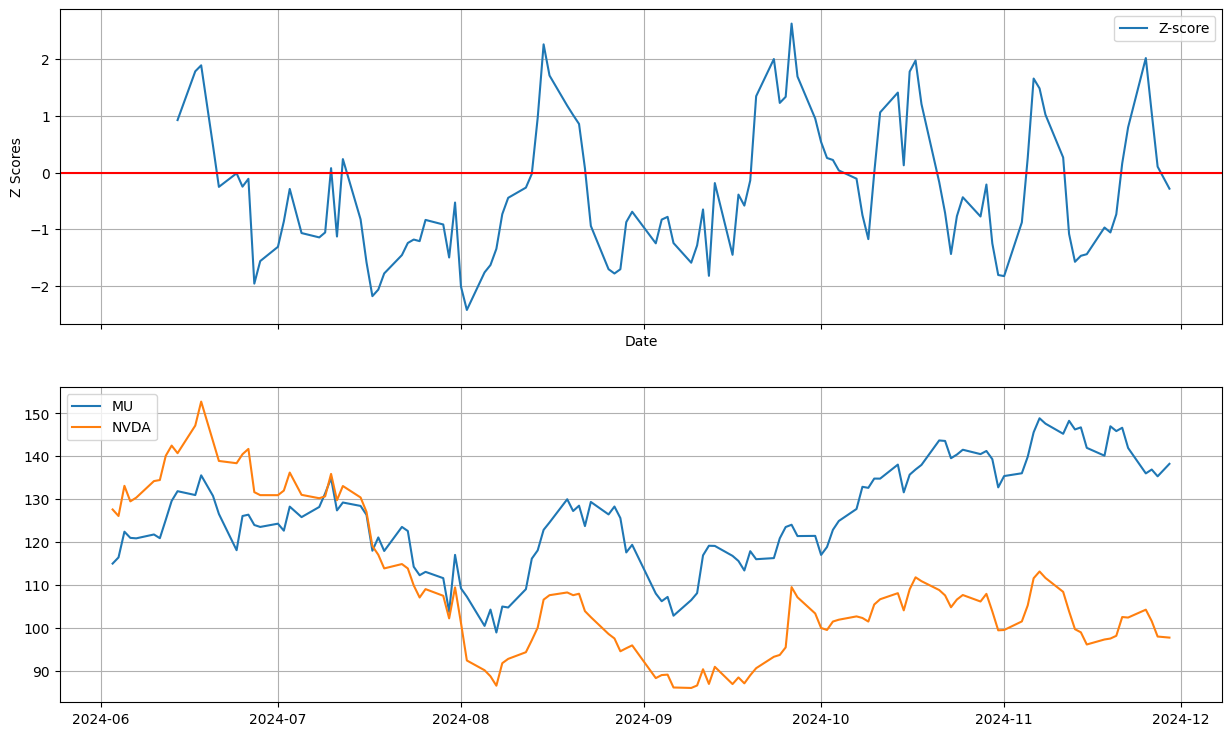

In [366]:
# Buy when z_score is below -1.5 -> Buy x Sell y
# Sell when z_score is 0 -> Sell x Buy y

# Sell when z_score is above +1.5 -> Sell x Buy y
# Buy when z_score is 0 -> Buy x Sell y
window=10
z_score = compute_z_score(lookback=None, rolling_window=window)

ZSCORE_ENTRY = 1.5
df = pd.DataFrame({"z_score":z_score})
df["z_signal"] = np.nan
df.loc[df.z_score<-ZSCORE_ENTRY, "z_signal"] =  1
df.loc[df.z_score>+ZSCORE_ENTRY, "z_signal"] =  -1
df.z_signal = df.z_signal.ffill()
df.loc[(df.z_score.shift(1)*df.z_score)<0,"BUY_or_SELL"] = 0

df['BUY_or_SELL'] = df.z_signal.diff()
# df.BUY_or_SELL = df.BUY_or_SELL.ffill()

df[-20:]

C:\Users\lOvIn\AppData\Local\Temp\ipykernel_4268\843259403.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]
C:\Users\lOvIn\AppData\Local\Temp\ipykernel_4268\843259403.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


,z_score,z_signal,BUY_or_SELL
Date,,,
2024-11-01,-1.826948,1.0,0.0
2024-11-04,-0.880208,1.0,0.0
2024-11-05,0.260316,1.0,0.0
2024-11-06,1.656797,-1.0,-2.0
2024-11-07,1.483132,-1.0,0.0
2024-11-08,1.019812,-1.0,0.0
2024-11-11,0.264747,-1.0,0.0
2024-11-12,-1.083117,-1.0,0.0
2024-11-13,-1.574527,1.0,2.0


In [361]:
df['BUY_or_SELL'].value_counts()

BUY_or_SELL
 0.0    94
-1.0    15
 1.0    15
Name: count, dtype: int64

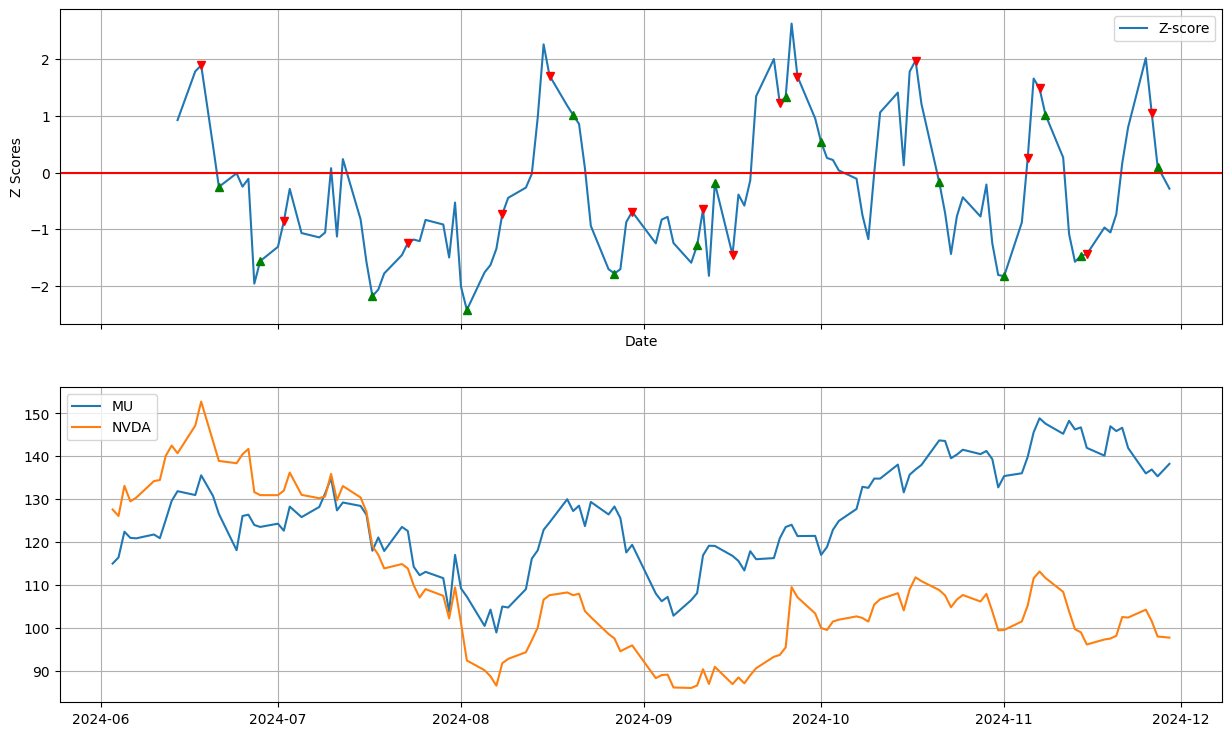

In [362]:
# Buy when z_score is below -1.5 -> Buy x Sell y
# Sell when z_score is 0 -> Sell x Buy y

# Sell when z_score is above +1.5 -> Sell x Buy y
# Buy when z_score is 0 -> Buy x Sell y


fig, axs = plt.subplots(2,1, figsize=(15,9), sharex=True)

axs[0].plot(df["z_score"], label="Z-score")
# axs[0].plot(z_score.rolling(window).mean(), label=f"Rolling Mean = {window} Periods")
axs[0].axhline(0,color='red')
axs[0].set_ylabel("Z Scores")
axs[0].set_xlabel("Date")
axs[0].legend()
axs[0].grid(True)
axs[0].plot(df.loc[df["BUY_or_SELL"] == -1].index, df.z_score[df["BUY_or_SELL"] == -1], color='r', marker="v", linestyle='')
axs[0].plot(df.loc[df["BUY_or_SELL"] == +1].index, df.z_score[df["BUY_or_SELL"] == +1], color='g', marker="^", linestyle='')
# axs[0].plot(df.loc[df["entry_exit"] == 0].index, df.z_score[df["entry_exit"] == 0], color='y', marker="o", linestyle='')


axs[1].plot(x_data, label="MU")
axs[1].plot(y_data, label="NVDA")
axs[1].legend()
axs[1].grid(True)

plt.show()